## - import

In [1]:
import os
import glob
import time
import random
import json
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### configuration

In [2]:
ROOT = "/content/drive/MyDrive/Final_Project/g25_dataset"
TRAIN_PATH = ROOT + "/train/images"
VALID_PATH = ROOT + "/valid/images"
TEST_PATH  = ROOT + "/test/images"
TRAIN_JSON = ROOT + "/train/annotations/g25_instances_train_sample.json"
VALID_JSON = ROOT + "/valid/annotations/g25_instances_valid_half.json"
TEST_JSON  = ROOT + "/test/annotations/g25_instances_test.json"

BEST_MODEL = True
BEST_MODEL_PATH = "/content/drive/MyDrive/FP/checkpoints/best_model_10-7_0.2154.pth"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

# Will be used to normalize pictures
# Normalize to resnet mean and std if True.
NORMALIZE = False
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 8

MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 0.001
USE_SCHEDULER = True
NUM_EPOCHS = 10

# Confidence required for a pixel to be kept for a mask
MASK_THRESHOLD = 0.5
MASK_THRESHOLD_DICT = {1: 0.5, 2: 0.75}
MIN_SCORE_DICT = {1: 0.59, 2: 0.75, 3: 0.5}

cpu


## - dataset

### 1. custom dataset

In [3]:
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, ann_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        # COCO
        self.coco = COCO(ann_file)
        self.ids = self.coco.getImgIds()
        self.catid_to_name = {cat['id']: cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())}

        # self.ids = list(self.coco.imgs.keys())
        # self.annotations = {ann['image_id']: [] for ann in self.coco.dataset['annotations']}
        # for ann in self.coco.dataset['annotations']:
        #     self.annotations[ann['image_id']].append(ann)

        # JSON
        # with open(ann_file, 'r') as f:
        #     self.coco = json.load(f)
        # self.ids = [img['id'] for img in self.coco['images']]
        # self.image_info = {img['id']: img for img in self.coco['images']}
        # self.annotations = {ann['image_id']: [] for ann in self.coco['annotations']}
        # for ann in self.coco['annotations']:
        #     self.annotations[ann['image_id']].append(ann)

    def __getitem__(self, index):
        img_id = self.ids[index]
        # img_info = self.image_info[img_id]
        img_info = self.coco.imgs[img_id]
        ann_info = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))

        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        areas = []
        labels = []
        masks = [] # 한 이미지에 3개의 객체가 있으면, masks 텐서는 각각 객체에 대응하는 3개의 2D 마스크를 포함해야 함.
        for ann in ann_info:
            xmin, ymin, width, height = ann['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            areas.append(ann['area'])
            labels.append(ann['category_id'])
            segm = ann['segmentation']
            masks.append(self.convert_to_mask(segm, img.size))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8) # (N, height, width) 크기의 텐서로, N은 이미지 내 객체의 수를 의미
        # iscrowd = torch.as_tensor([ann['iscrowd'] for ann in ann_info], dtype=torch.int64)
        iscrowd = torch.zeros((len(ann_info),), dtype=torch.int64)
        image_id = torch.tensor([img_id])

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'area': areas,
            'image_id': image_id,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

    def convert_to_mask(self, segment, image_size):
        mask = Image.new('L', image_size, 0)
        ImageDraw.Draw(mask).polygon(segment, outline=1, fill=1)
        return mask # <PIL.Image.Image image mode=L size=512x512>

### 2. transforms

In [4]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class RandomHorizontalFlip: # x, width
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.hflip(image)
            target["boxes"] = self.flip_boxes(target["boxes"], image.shape[-1])
            target["masks"] = target["masks"].flip(-1) # PIL Iamge Object
        return image, target

    def flip_boxes(self, boxes, width):
        boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
        return boxes

class RandomVerticalFlip: # y, height
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.vflip(image)
            target["boxes"] = self.flip_boxes(target["boxes"], image.shape[-2])
            target["masks"] = target["masks"].flip(-2)
        return image, target

    def flip_boxes(self, boxes, height):
        boxes[:, [1, 3]] = height - boxes[:, [3, 1]]
        return boxes

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for training dataset
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))

    return Compose(transforms)

In [5]:
train_dataset = SolarPanelDataset(image_dir=TRAIN_PATH, ann_file=TRAIN_JSON, transforms=get_transform(train=True))
len(train_dataset)#, train_dataset[0]

loading annotations into memory...
Done (t=2.80s)
creating index...
index created!


10632

In [ ]:
valid_dataset = SolarPanelDataset(image_dir=VALID_PATH, ann_file=VALID_JSON, transforms=get_transform(train=False))
len(valid_dataset)#, valid_dataset[0]

loading annotations into memory...
Done (t=1.48s)
creating index...
index created!


1181

In [6]:
test_dataset = SolarPanelDataset(image_dir=TEST_PATH, ann_file=TEST_JSON, transforms=get_transform(train=False))
len(test_dataset)#, test_dataset[0]

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!


1181

### 3. dataloader

In [7]:
train_dloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
len(train_dloader)

1329

In [ ]:
valid_dloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
len(valid_dloader)

148

In [8]:
test_dloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
len(test_dloader)

148

## - modeling

### 1. model fine-tuning

In [9]:
# 모델 로드 및 수정
model = maskrcnn_resnet50_fpn_v2(weights='MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
# num_classes = 4  # 3 class (object) + background

# Bounding box predictor 수정
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Mask predictor 수정
# hidden_layer 값을 늘리거나 줄여서 모델의 성능을 비교해 볼 수 있습니다. (default=256)
# 예를 들어, 더 복잡한 데이터셋이나 더 많은 클래스가 있는 경우 hidden_layer 값을 늘리면 성능이 향상될 수 있습니다.
# 반면, 계산 자원을 절약하거나 더 작은 데이터셋에 대해 과적합을 방지하려면 값을 줄일 수 있습니다.
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

if BEST_MODEL:
    if DEVICE == 'cuda':
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cuda')))
    else:
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cpu')))
    print("load best model")

# Device 설정
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:02<00:00, 66.2MB/s]


load best model


In [ ]:
fix_layer=[]; trainable=[];
idx = 0
for param in model.parameters():
    if param.requires_grad:
        trainable.append(idx)
    else:
        fix_layer.append(idx)
    idx += 1
print("고정층:", fix_layer)
print("학습층:", trainable)

고정층: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
학습층: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

### 4. visualize result



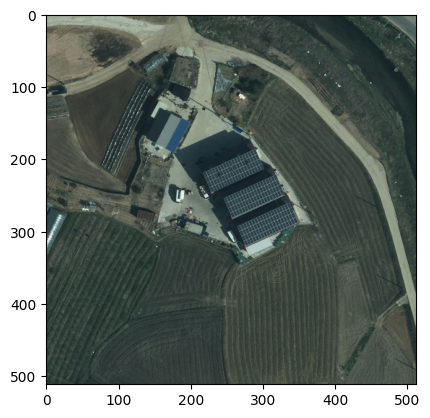

In [10]:
model.eval()
with torch.no_grad():
    for images, targets in test_dloader:
        images = list(img.to(DEVICE) for img in images)
        outputs = model(images)

        # Display results
        for i in range(len(images)):
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            # images[i].shape = torch.Size([3, 512, 512])
            # └─> img.shape = (512, 512, 3)
            plt.imshow(img)
            plt.show()
            break
        break

In [ ]:
images[0].shape

torch.Size([3, 512, 512])

In [ ]:
# img = images[i].cpu().numpy().transpose((1, 2, 0))
img.shape

(512, 512, 3)

In [ ]:
outputs

[{'boxes': tensor([[264.5599, 260.0116, 348.5632, 320.8912],
          [216.7839, 186.2011, 300.9419, 248.1848],
          [125.5068, 271.2496, 152.5405, 288.5068],
          [245.1460, 222.0724, 329.9372, 282.1143],
          [245.0652, 222.0251, 330.0337, 282.7800],
          [264.4688, 261.0105, 348.4198, 321.4430],
          [215.4395, 186.7125, 301.6440, 247.5318],
          [ 75.4008,  93.6553, 144.5152, 221.7331],
          [ 73.7261,  93.2193, 147.8214, 219.6603]], device='cuda:0'),
  'labels': tensor([1, 1, 2, 1, 2, 2, 2, 1, 2], device='cuda:0'),
  'scores': tensor([0.9422, 0.9329, 0.9278, 0.9018, 0.3266, 0.2979, 0.2324, 0.1795, 0.1663],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0.,

In [ ]:
outputs[0]

{'boxes': tensor([[264.5599, 260.0116, 348.5632, 320.8912],
         [216.7838, 186.2011, 300.9419, 248.1848],
         [125.5068, 271.2496, 152.5405, 288.5068],
         [245.1460, 222.0724, 329.9372, 282.1143],
         [245.0652, 222.0251, 330.0337, 282.7800],
         [264.4688, 261.0105, 348.4198, 321.4431],
         [215.4395, 186.7125, 301.6440, 247.5318],
         [ 75.4008,  93.6553, 144.5153, 221.7331],
         [ 73.7261,  93.2193, 147.8214, 219.6603]]),
 'labels': tensor([1, 1, 2, 1, 2, 2, 2, 1, 2]),
 'scores': tensor([0.9422, 0.9329, 0.9278, 0.9018, 0.3266, 0.2979, 0.2324, 0.1795, 0.1663]),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0.

In [ ]:
outputs[0]['masks'].shape

torch.Size([9, 1, 512, 512])

In [ ]:
outputs[0]['masks'][:,0,:,:].shape

torch.Size([9, 512, 512])

In [ ]:
masks = outputs[0]['masks'].cpu().numpy()
masks.shape

(9, 1, 512, 512)

In [ ]:
masks.squeeze(axis=1).shape

(9, 512, 512)

In [ ]:
masks[0].shape, masks[0].squeeze().shape

((1, 512, 512), (512, 512))

In [ ]:
bboxes = outputs[0]['boxes'].cpu().numpy()
bboxes.shape

(9, 4)

In [ ]:
labels = outputs[0]['labels'].cpu().numpy()
labels

array([1, 1, 2, 1, 2, 2, 2, 1, 2])

In [ ]:
label_dic = test_dataset.catid_to_name
label_dic

{1: 'Building', 2: 'Ground', 3: 'Water'}

In [ ]:
labels_nm = [label_dic[label] for label in labels]
labels_nm

['Building',
 'Building',
 'Ground',
 'Building',
 'Ground',
 'Ground',
 'Ground',
 'Building',
 'Ground']

In [ ]:
scores = outputs[0]['scores'].cpu().numpy()#.round(2)
scores

array([0.9422306 , 0.93287855, 0.9278477 , 0.9017883 , 0.32658675,
       0.29794767, 0.23237641, 0.17951499, 0.1663421 ], dtype=float32)

In [ ]:
for mask, bbox, label, score in zip(masks[:,0,:,:], bboxes, labels, scores):
    print(mask.shape, bbox, label, score)

(512, 512) [264.5599  260.01163 348.5632  320.89117] 1 0.9422306
(512, 512) [216.78384 186.20113 300.9419  248.18484] 1 0.93287855
(512, 512) [125.50678 271.2496  152.54053 288.50684] 2 0.9278477
(512, 512) [245.14595 222.07236 329.9372  282.11426] 1 0.9017883
(512, 512) [245.06516 222.02509 330.0337  282.78   ] 2 0.32658675
(512, 512) [264.46878 261.0105  348.41983 321.44305] 2 0.29794767
(512, 512) [215.43953 186.71254 301.64398 247.53175] 2 0.23237641
(512, 512) [ 75.400795  93.65525  144.51527  221.73312 ] 1 0.17951499
(512, 512) [ 73.72608  93.21934 147.82143 219.66031] 2 0.1663421


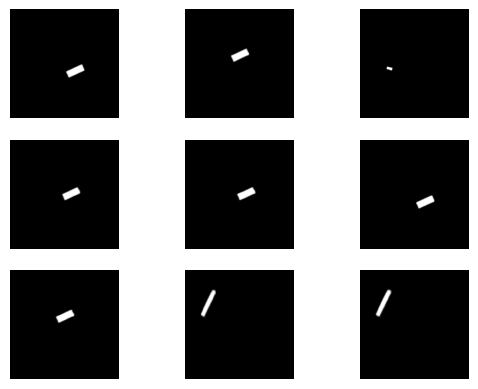

In [ ]:
# plt.figure(figsize=(12, 12))
for i, mask in enumerate(masks[:,0,:,:]):
    plt.subplot(3, 3, i+1)
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

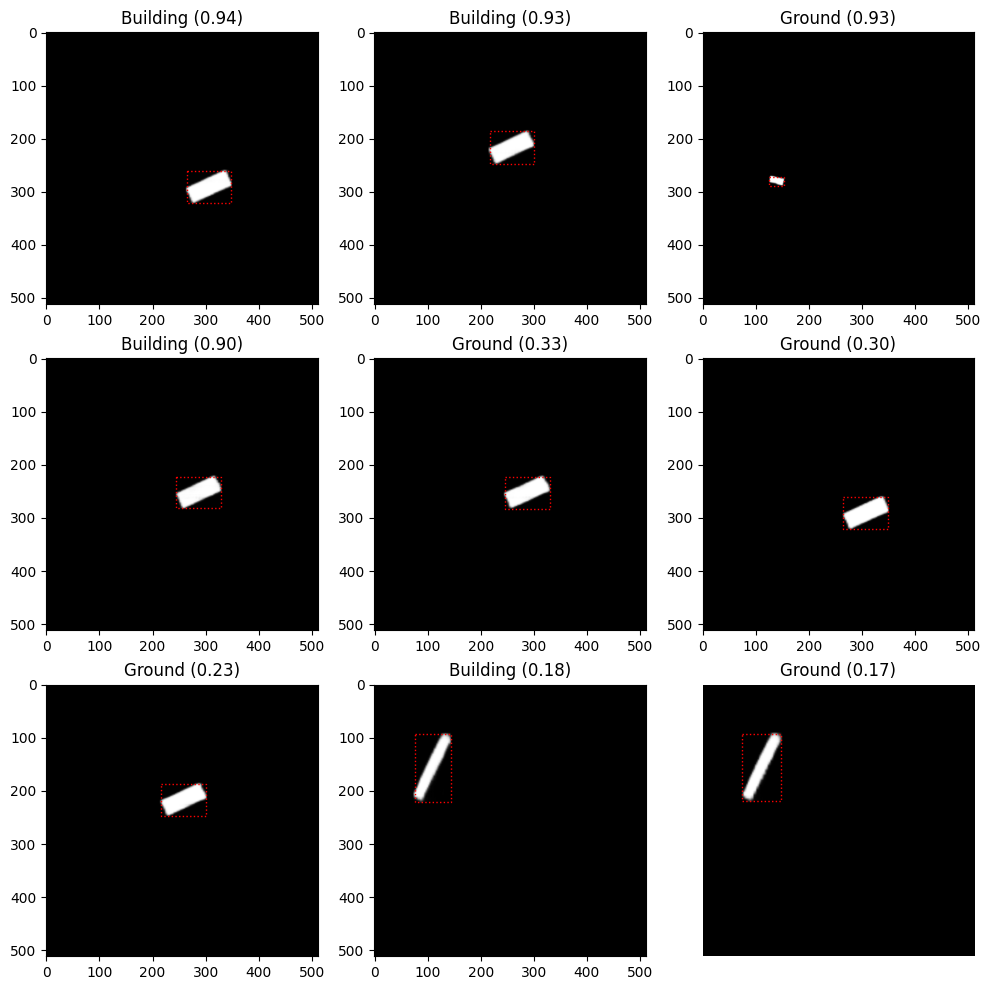

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

masks = masks.sqeeze(axis=1)
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
i=0
for mask, bbox, label, score in zip(masks, bboxes, labels_nm, scores):
    axs[i//3, i%3].imshow(mask, cmap=plt.cm.gray)
    axs[i//3, i%3].set_title(f"{label} ({score:.2f})")
    x1, y1, x2, y2 = bbox
    rect = Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=1, edgecolor='r', facecolor='none', linestyle='dotted')
    axs[i//3, i%3].add_patch(rect)
    plt.axis('off')
    i+=1
plt.show()

0.94
0.93
0.93
0.9


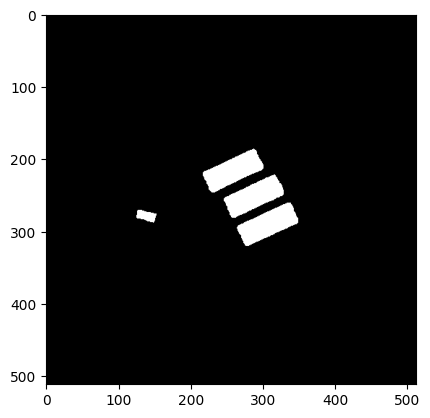

In [ ]:
all_masks = np.zeros((512, 512))
for mask, score in zip(masks[:,0,:,:], scores):
    if score < 0.5:
        continue
    print(score)
    # print(mask[0].shape)
    all_masks = np.logical_or(all_masks, mask>0.5)

plt.imshow(all_masks, cmap=plt.cm.gray)
plt.show()

In [ ]:
outputs[0]['scores'].cpu().numpy()

array([0.9422306 , 0.93287855, 0.9278477 , 0.9017883 , 0.32658675,
       0.29794767, 0.23237641, 0.17951499, 0.1663421 ], dtype=float32)

In [ ]:
outputs[0]["scores"][0].cpu().item()

0.9422305822372437

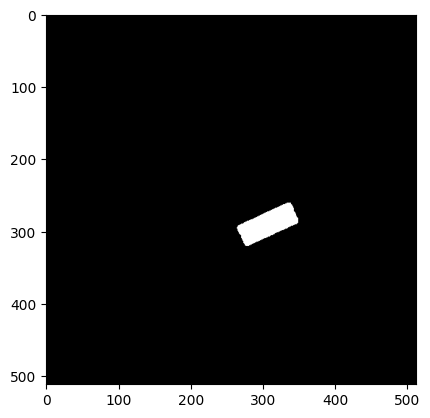

0


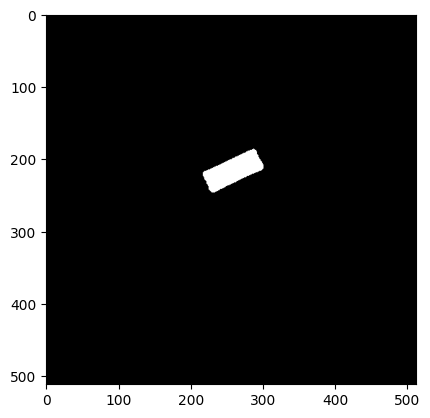

0
0


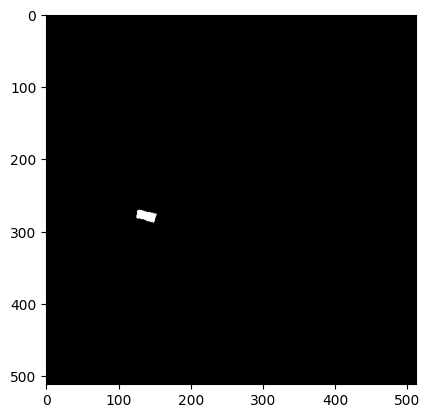

0
0
0


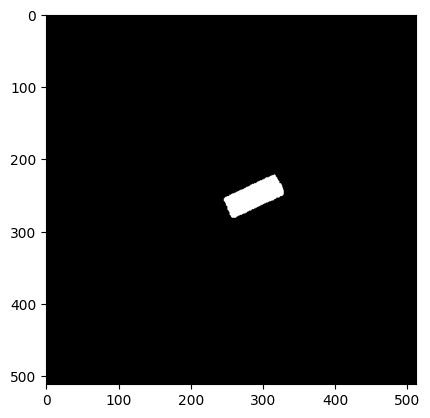

0
0
0
2503


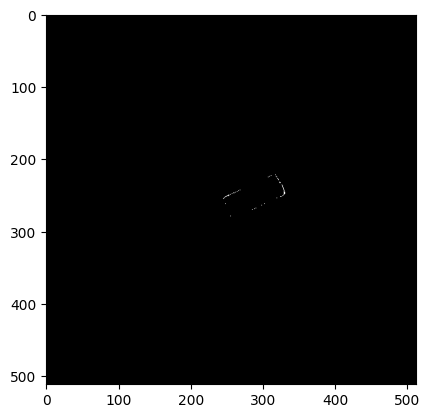

2579
0
0
0
0


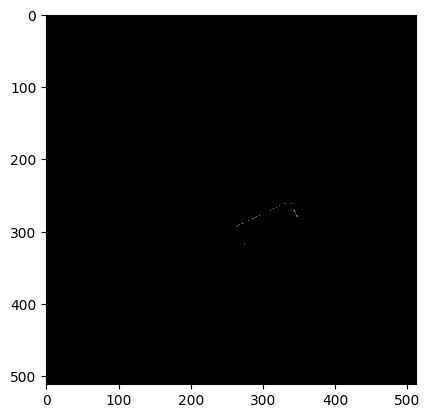

0
2523
0
0
0
0


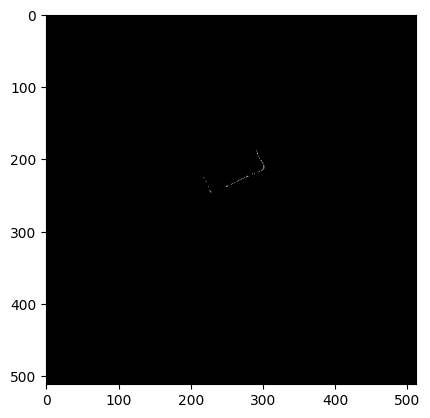

0
0
0
0
0
0
0


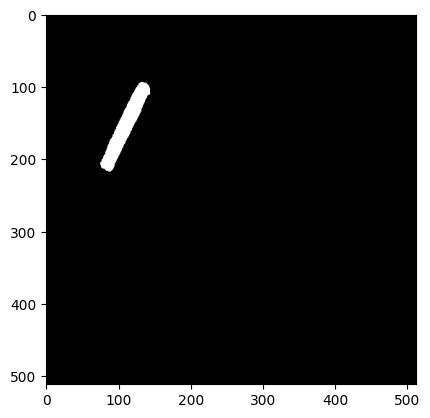

0
0
0
0
0
0
0
2563


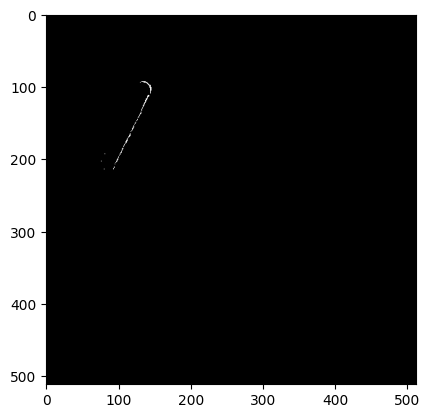

In [ ]:
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        print(np.sum(np.logical_and(mask, other_mask)))
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

previous_masks = []
for score, mask in zip(scores, masks):
    binary_mask = mask > 0.5
    binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
    previous_masks.append(binary_mask)
    plt.imshow(binary_mask[0,:,:], cmap=plt.cm.gray)
    plt.show()

In [ ]:
import torch

# 예시 데이터
target_labels = torch.tensor([1, 1, 1])
pred_labels = torch.tensor([1, 1, 2, 1, 2, 2, 2, 1, 2])
pred_scores = torch.tensor([0.9422, 0.9329, 0.9278, 0.9018, 0.3266, 0.2979, 0.2324, 0.1795, 0.1663])

# 임계값 설정
threshold = 0.5

# 임계값 이상의 예측 선택
high_conf_indices = pred_scores > threshold
filtered_pred_labels = pred_labels[high_conf_indices]

# True Positive, False Positive, False Negative 계산
tp = 0
fp = 0
fn = 0

for label in target_labels:
    if label in filtered_pred_labels:
        tp += 1
        # 해당 label을 제거하여 중복 counting 방지
        idx = (filtered_pred_labels == label).nonzero(as_tuple=True)[0][0]
        filtered_pred_labels = torch.cat((filtered_pred_labels[:idx], filtered_pred_labels[idx+1:]))
    else:
        fn += 1

fp = len(filtered_pred_labels)  # 남은 pred_labels는 모두 False Positive

# Precision, Recall, F1-Score 계산
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

tensor([1, 1, 2, 1])
tensor([0.9422, 0.9329, 0.9278, 0.9018])
tensor(0)
tensor([1, 2, 1])
tensor(0)
tensor([2, 1])
tensor(1)
tensor([2])
Precision: 0.7500
Recall: 1.0000
F1-Score: 0.8571


In [ ]:
import torch

# 예시 데이터
target_labels = torch.tensor([1, 1, 1])
pred_labels = torch.tensor([1, 1, 2, 1, 2, 2, 2, 1, 2])
pred_scores = torch.tensor([0.9422, 0.9329, 0.9278, 0.9018, 0.3266, 0.2979, 0.2324, 0.1795, 0.1663])

# 임계값 설정
threshold = 0.5

# 임계값 이상의 예측 선택
# MIN_SCORE = 0.5
# keep = pred_scores > MIN_SCORE
high_conf_indices = pred_scores > threshold
filtered_pred_labels = pred_labels[high_conf_indices].cpu()

# target_labels는 이미 cpu에 있으므로 바로 사용
target_labels = target_labels.cpu()

# TP, FP, FN 계산
tp = 0
fp = 0
fn = 0

filtered_pred_labels_list = filtered_pred_labels.tolist()
# target_labels_list = target_labels.tolist()

for label in target_labels:#_list
    if label in filtered_pred_labels_list:
        tp += 1
        # 해당 label을 제거하여 중복 counting 방지
        filtered_pred_labels_list.remove(label)
        print(filtered_pred_labels_list)
    else:
        fn += 1

fp = len(filtered_pred_labels_list)  # 남은 pred_labels는 모두 False Positive

# Precision, Recall, F1-Score, Accuracy 계산
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
accuracy = tp / len(target_labels) if len(target_labels) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

[1, 2, 1]
[2, 1]
[2]
Precision: 0.7500
Recall: 1.0000
F1-Score: 0.8571
Accuracy: 1.0000


In [ ]:
for t, o in zip(targets, outputs):
    print(t['labels'])
    print(o['labels'])
    print(o['scores'])

tensor([1, 1, 1])
tensor([1, 1, 2, 1, 2, 2, 2, 1, 2])
tensor([0.9422, 0.9329, 0.9278, 0.9018, 0.3266, 0.2979, 0.2324, 0.1795, 0.1663])
tensor([1])
tensor([1, 1, 1, 1])
tensor([0.9896, 0.8117, 0.1877, 0.0854])
tensor([2])
tensor([1, 2, 2])
tensor([0.6921, 0.5427, 0.0590])
tensor([1, 1])
tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0.9965, 0.9915, 0.6609, 0.5374, 0.3510, 0.2522, 0.2511, 0.2190, 0.1439,
        0.1283, 0.1081, 0.1074, 0.1011, 0.0623])
tensor([2])
tensor([2, 2, 2, 1])
tensor([0.9173, 0.2116, 0.2091, 0.1300])
tensor([1])
tensor([1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 2, 3, 3])
tensor([0.9109, 0.6786, 0.3521, 0.3211, 0.3191, 0.2916, 0.2032, 0.1978, 0.1854,
        0.1673, 0.1379, 0.0866, 0.0677, 0.0559, 0.0551])
tensor([1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 2, 1, 2, 2, 2, 1, 2, 3, 3, 1, 2])
tensor([0.9903, 0.9766, 0.9562, 0.9319, 0.8791, 0.7850, 0.4517, 0.3712, 0.2927,
        0.2587, 0.2138, 0.1336, 0.1303, 0.1106, 0.0995, 0.0902, 0.0876, 0.

In [ ]:
for m, mask in enumerate(outputs[0]['masks'],1):
    print(m, mask.shape)

1 torch.Size([1, 512, 512])
2 torch.Size([1, 512, 512])
3 torch.Size([1, 512, 512])
4 torch.Size([1, 512, 512])
5 torch.Size([1, 512, 512])
6 torch.Size([1, 512, 512])
7 torch.Size([1, 512, 512])
8 torch.Size([1, 512, 512])
9 torch.Size([1, 512, 512])


In [ ]:
for mask in masks:
    print(mask.squeeze().shape)
    print(mask.shape)
    break

(512, 512)
(1, 512, 512)


In [ ]:
def combine_masks(masks, mask_threshold):
    """
    Combine masks into one image.
    """
    maskimg = np.zeros((512, 512))
    for m, mask in enumerate(masks,1):
        mask = mask.squeeze()
        maskimg[mask>mask_threshold] = m
    return maskimg

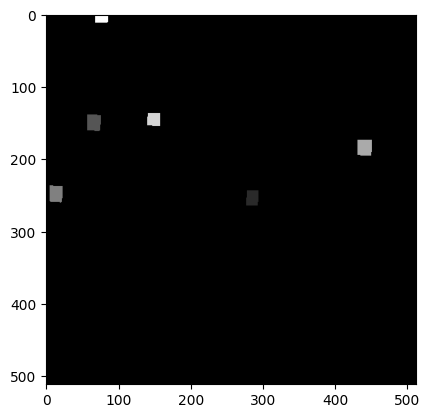

In [ ]:
# pred_masks = combine_masks(masks[:4,0,:,:], 0.5)
pred_masks = combine_masks(outputs[6]['masks'][:6,0,:,:],0.5)
plt.imshow(pred_masks, cmap=plt.cm.gray)
plt.show()

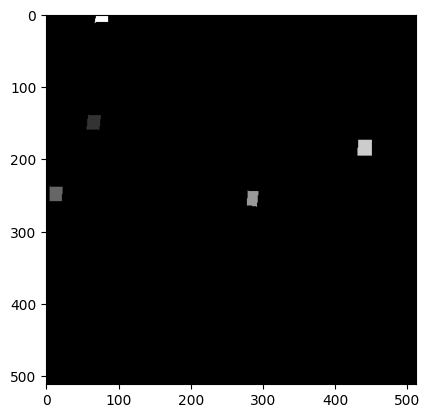

In [ ]:
true_masks = combine_masks(targets[6]['masks'], 0.5)
plt.imshow(true_masks, cmap=plt.cm.gray)
plt.show()

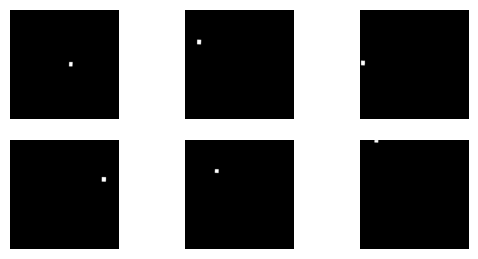

In [11]:
for i, mask in enumerate(outputs[6]['masks'][:6,0,:,:]):
    plt.subplot(3, 3, i+1)
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

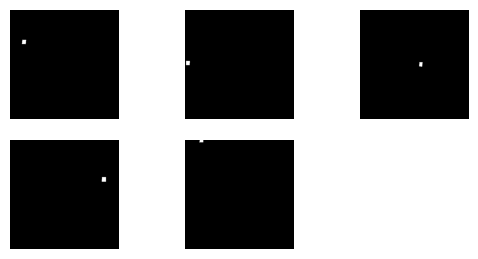

In [12]:
for i, mask in enumerate(targets[6]['masks']):
    plt.subplot(3, 3, i+1)
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

In [ ]:
# iou = [[0.        , 0.85611511, 0.        , 0.        , 0.        ,        0.        ],
#        [0.        , 0.        , 0.88413098, 0.        , 0.        ,        0.        ],
#        [0.83714286, 0.        , 0.        , 0.        , 0.        ,        0.        ],
#        [0.        , 0.        , 0.        , 0.95454545, 0.        ,        0.        ],
#        [0.        , 0.        , 0.        , 0.        , 0.        ,        0.89767442]]

In [ ]:
true_objs = len(np.unique(true_masks))
pred_objs = len(np.unique(pred_masks))
print("Number of true objects: {}".format(true_objs))
print("Number of predicted objects: {}".format(pred_objs))

Number of true objects: 6
Number of predicted objects: 7


In [ ]:
np.unique(pred_masks)

array([0., 1., 2., 3., 4., 5., 6.])

In [ ]:
histo2d = np.histogram2d(x=true_masks.flatten(), y=pred_masks.flatten(), bins=(true_objs, pred_objs))
histo2d

(array([[2.60013e+05, 4.90000e+01, 5.50000e+01, 4.60000e+01, 1.10000e+01,
         3.12000e+02, 2.10000e+01],
        [5.00000e+00, 0.00000e+00, 3.57000e+02, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, 3.51000e+02, 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [8.00000e+00, 2.93000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [9.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.20000e+02,
         0.00000e+00, 0.00000e+00],
        [1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 1.93000e+02]]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]))

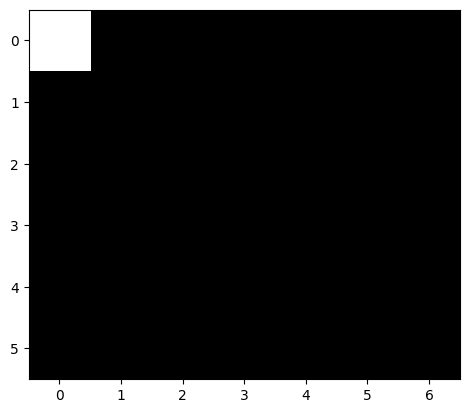

In [ ]:
intersection = histo2d[0]
plt.imshow(intersection, cmap=plt.cm.gray)
plt.show()

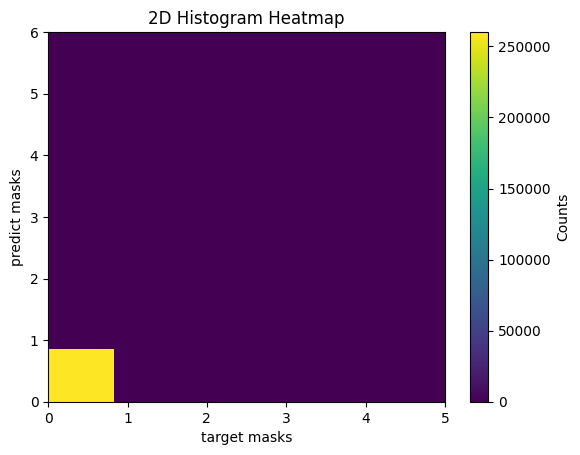

In [ ]:
hist, xedges, yedges = histo2d

# 히트맵 시각화
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.colorbar(label='Counts')
plt.xlabel('target masks')
plt.ylabel('predict masks')
plt.title('2D Histogram Heatmap')
plt.show()

In [ ]:
area_true = np.histogram(true_masks, bins=true_objs)[0]
area_true

array([260507,    362,    351,    301,    429,    194])

In [ ]:
np.expand_dims(area_true, axis=0)

array([[260507,    362,    351,    301,    429,    194]])

In [ ]:
area_true = np.expand_dims(area_true, axis=-1)
area_true

array([[260507],
       [   362],
       [   351],
       [   301],
       [   429],
       [   194]])

In [ ]:
area_pred = np.histogram(pred_masks, bins=pred_objs)[0]
area_pred

array([260036,    342,    412,    397,    431,    312,    214])

In [ ]:
area_pred = np.expand_dims(area_pred, axis=0)
area_pred

array([[260036,    342,    412,    397,    431,    312,    214]])

In [ ]:
union = area_true + area_pred - intersection
union

array([[2.60530e+05, 2.60800e+05, 2.60864e+05, 2.60858e+05, 2.60927e+05,
        2.60507e+05, 2.60700e+05],
       [2.60393e+05, 7.04000e+02, 4.17000e+02, 7.59000e+02, 7.93000e+02,
        6.74000e+02, 5.76000e+02],
       [2.60387e+05, 6.93000e+02, 7.63000e+02, 3.97000e+02, 7.82000e+02,
        6.63000e+02, 5.65000e+02],
       [2.60329e+05, 3.50000e+02, 7.13000e+02, 6.98000e+02, 7.32000e+02,
        6.13000e+02, 5.15000e+02],
       [2.60456e+05, 7.71000e+02, 8.41000e+02, 8.26000e+02, 4.40000e+02,
        7.41000e+02, 6.43000e+02],
       [2.60229e+05, 5.36000e+02, 6.06000e+02, 5.91000e+02, 6.25000e+02,
        5.06000e+02, 2.15000e+02]])

In [ ]:
intersection = intersection[1:, 1:]
union = union[1:, 1:]
intersection, union

(array([[  0., 357.,   0.,   0.,   0.,   0.],
        [  0.,   0., 351.,   0.,   0.,   0.],
        [293.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 420.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 193.]]),
 array([[704., 417., 759., 793., 674., 576.],
        [693., 763., 397., 782., 663., 565.],
        [350., 713., 698., 732., 613., 515.],
        [771., 841., 826., 440., 741., 643.],
        [536., 606., 591., 625., 506., 215.]]))

In [ ]:
union[union == 0] = 1e-9
union

array([[704., 417., 759., 793., 674., 576.],
       [693., 763., 397., 782., 663., 565.],
       [350., 713., 698., 732., 613., 515.],
       [771., 841., 826., 440., 741., 643.],
       [536., 606., 591., 625., 506., 215.]])

In [ ]:
iou = intersection / union
iou

array([[0.        , 0.85611511, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.88413098, 0.        , 0.        ,
        0.        ],
       [0.83714286, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.95454545, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.89767442]])

In [ ]:
objs_iou = []
for obj_iou in iou:
    print(max(obj_iou))
    objs_iou.append(max(obj_iou))
sum(objs_iou) / len(iou)

0.8561151079136691
0.8841309823677582
0.8371428571428572
0.9545454545454546
0.8976744186046511


0.885921764114878

In [ ]:
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou
calculate_iou(pred_masks, true_masks)

0.7573908962928203

In [ ]:
matches = iou > 0.5
matches

array([[False,  True, False, False, False, False],
       [False, False,  True, False, False, False],
       [ True, False, False, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False, False,  True]])

In [ ]:
np.sum(matches, axis=1) # ground true objects

array([1, 1, 1, 1, 1])

In [ ]:
np.sum(matches, axis=0) # predict objects

array([1, 1, 1, 1, 0, 1])

In [ ]:
true_positives = np.sum(matches, axis=1) == 1  # Correct objects
false_positives = np.sum(matches, axis=0) == 0  # Missed objects
false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
true_positives, false_positives, false_negatives

(array([ True,  True,  True,  True,  True]),
 array([False, False, False, False,  True, False]),
 array([False, False, False, False, False]))

In [ ]:
tp, fp, fn = (
    np.sum(true_positives),
    np.sum(false_positives),
    np.sum(false_negatives),
)
tp, fp, fn

(5, 1, 0)

In [ ]:
tp / (tp + fp + fn)

0.8333333333333334

In [ ]:
from collections import defaultdict

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

verbose = True
if verbose:
    print("Threshold\tTP\tFP\tFN\tPrec.")

prec = []; precisions=[]; recalls=[]
results = defaultdict(dict)
for t in np.arange(0.5, 1.0, 0.05):
    # tps, fps, fns = 0, 0, 0
    tp, fp, fn = precision_at(t, iou)
    # tps += tp
    # fps += fp
    # fns += fn

    p = tp / (tp + fp + fn)
    prec.append(p)

    # Precision, Recall, F1-Score, Accuracy 계산
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    # accuracy = tp / len(target_labels) if len(target_labels) > 0 else 0
    results[t]['tp'] = tp
    results[t]['fp'] = fp
    results[t]['fn'] = fn
    results[t]['precision'] = precision
    results[t]['recall'] = recall
    results[t]['f1_score'] = f1_score
    precisions.append(precision)
    recalls.append(recall)

    if verbose:
        print("{:1.3f} [mAP@{}]\t{}\t{}\t{}\t{:1.3f}".format(round(t,2), (round(t*100)), tp, fp, fn, p))

if verbose:
    print("mAP50-95\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Threshold	TP	FP	FN	Prec.
0.500 [mAP@50]	5	1	0	0.833
0.550 [mAP@55]	5	1	0	0.833
0.600 [mAP@60]	5	1	0	0.833
0.650 [mAP@65]	5	1	0	0.833
0.700 [mAP@70]	5	1	0	0.833
0.750 [mAP@75]	5	1	0	0.833
0.800 [mAP@80]	5	1	0	0.833
0.850 [mAP@85]	4	2	1	0.571
0.900 [mAP@90]	1	5	4	0.100
0.950 [mAP@95]	1	5	4	0.100
mAP50-95	-	-	-	0.660


In [ ]:
dict(results)

{0.5: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.55: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.6000000000000001: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.6500000000000001: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.7000000000000002: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.7500000000000002: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.8000000000000003: {'tp': 5,
  'fp': 1,
  'fn': 0,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1_score': 0.9090909090909091},
 0.8500000000000003: {'tp': 4,
  'fp': 2,
  'fn':

In [ ]:
recalls, precisions

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.2, 0.2],
 [0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.6666666666666666,
  0.16666666666666666,
  0.16666666666666666])

In [ ]:
recalls.reverse()
precisions.reverse()
recalls, precisions

([0.2, 0.2, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.16666666666666666,
  0.16666666666666666,
  0.6666666666666666,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334])

In [ ]:
def calculate_ap(recall, precision):
    # 보간법(interpolation)을 사용하여 AP 계산
    mrecall = np.concatenate(([0.0], recall, [1.0]))
    mprecision = np.concatenate(([0.0], precision, [0.0]))

    # Precision의 누적 최대값 구하기
    for i in range(mprecision.size - 1, 0, -1):
        mprecision[i - 1] = np.maximum(mprecision[i - 1], mprecision[i])

    # Recall의 변화가 있는 지점에서만 AP 계산
    changing_points = np.where(mrecall[1:] != mrecall[:-1])[0]
    ap = np.sum((mrecall[changing_points + 1] - mrecall[changing_points]) * mprecision[changing_points + 1])
    return ap

ap = calculate_ap(recalls, precisions)
ap

0.8333333333333334

In [ ]:
import numpy as np

def compute_bbox_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Parameters
    ----------
    box1 : list, tuple or np.ndarray
        (x1, y1, x2, y2) coordinates of the first box
    box2 : list, tuple or np.ndarray
        (x1, y1, x2, y2) coordinates of the second box
    Returns
    -------
    float
        in [0, 1]. IoU of box1 and box2
    """
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    # Compute the area of intersection rectangle
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Compute the area of both bounding boxes
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y2_)

    # Compute the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

In [ ]:
gt_boxes = targets[0]['boxes']
gt_labels = targets[0]['labels']
gt_boxes, gt_labels

(tensor([[217.0546, 186.4258, 301.5403, 247.0688],
         [246.0019, 221.9344, 329.9603, 282.1589],
         [263.9506, 259.9085, 349.3923, 321.1714]]),
 tensor([1, 1, 1]))

In [ ]:
tp = 0
fp = 0
fn = 0
iou_threshold = 0.5
matched_gt_indices = []

for i in range(len(bboxes)):
    print("pred_bbox[%d]" % i)
    pred_box = bboxes[i]
    pred_label = labels[i]
    pred_score = scores[i]

    if pred_score < iou_threshold:
        continue

    max_iou = 0
    max_iou_gt_index = -1

    for j in range(len(gt_boxes)):
        print(j)
        if j in matched_gt_indices:
            continue

        gt_box = gt_boxes[j]
        gt_label = gt_labels[j]

        if pred_label != gt_label:
            continue

        iou = compute_bbox_iou(pred_box, gt_box)
        print(f"iou --> {iou}, max_iou --> {max_iou}")

        if iou > max_iou:
            max_iou = iou
            max_iou_gt_index = j

    if max_iou >= iou_threshold:
        tp += 1
        matched_gt_indices.append(max_iou_gt_index)
        print("Match --> gt_bbox[%d]" % max_iou_gt_index)
    else:
        fp += 1
    print(matched_gt_indices, end="\n\n")

fn = len(gt_boxes) - len(matched_gt_indices)
tp, fp, fn

pred_bbox[0]
0
iou --> 0.0, max_iou --> 0
1
iou --> 0.3951394259929657, max_iou --> 0
2
iou --> inf, max_iou --> 0.3951394259929657
Match --> gt_bbox[2]
[2]

pred_bbox[1]
0
iou --> 39.359519958496094, max_iou --> 0
1
iou --> 0.3821174204349518, max_iou --> 39.359519958496094
2
Match --> gt_bbox[0]
[2, 0]

pred_bbox[2]
0
1
2
[2, 0]

pred_bbox[3]
0
1
iou --> 98.05682373046875, max_iou --> 0
2
Match --> gt_bbox[1]
[2, 0, 1]

pred_bbox[4]
pred_bbox[5]
pred_bbox[6]
pred_bbox[7]
pred_bbox[8]


(3, 1, 0)

### 5. model 성능 : mAP@70

In [13]:
img, target = test_dataset[0]
img.shape, target

(torch.Size([3, 512, 512]),
 {'boxes': tensor([[217.0546, 186.4258, 301.5403, 247.0688],
          [246.0019, 221.9344, 329.9603, 282.1589],
          [263.9506, 259.9085, 349.3923, 321.1714]]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'area': tensor([512

In [14]:
target['image_id'].item()

0

In [15]:
target['boxes'].cpu().numpy().tolist()

[[217.05462646484375,
  186.42575073242188,
  301.5402526855469,
  247.0688018798828],
 [246.00193786621094,
  221.93438720703125,
  329.96026611328125,
  282.1589050292969],
 [263.95062255859375, 259.9084777832031, 349.3923034667969, 321.1713562011719]]

In [ ]:
from collections import defaultdict

ground_true = defaultdict(dict)
predictions = defaultdict(dict)

model.eval()
with torch.no_grad():
    for img, target in test_dataset:
        output = model([img.to(DEVICE)])

        ground_true[target['image_id'].item()]['boxes'] = target['boxes'].cpu().numpy().tolist()
        ground_true[target['image_id'].item()]['area'] = target['area'].cpu().numpy().tolist()
        ground_true[target['image_id'].item()]['labels'] = target['labels'].cpu().numpy().tolist()
        ground_true[target['image_id'].item()]['masks'] = target['masks'].cpu().numpy().tolist()

        # for k, v in output[0].items():
        #     # output[k] = v.cpu().numpy().tolist()
        # predictions[target['image_id'].item()] = output
        break

ground_true, predictions

In [ ]:
from collections import defaultdict

test_coco = test_dataset.coco
ground_trues = defaultdict(dict)
predictions = defaultdict(dict)

model.eval()
with torch.no_grad():
    for img, target in test_dataset:
        output = model([img.to(DEVICE)])[0]

        target_img_id = target['image_id'].item()
        ground_trues[target_img_id]['boxes'] = target['boxes'].cpu().numpy()
        ground_trues[target_img_id]['area'] = target['area'].cpu().numpy()
        ground_trues[target_img_id]['labels'] = target['labels'].cpu().numpy()
        ground_trues[target_img_id]['masks'] = target['masks'].cpu().numpy()

        predict = output.copy()
        keep = predict['scores'] > 0.5
        for k, v in output.items():
            np_val = v.cpu().numpy()
            output[k] = np_val
            predict[k] = np_val[keep]
        predictions[target_img_id] = output
        break

dict(ground_trues), dict(predictions)

### eval

In [ ]:
 'categories': [{'id': 1, 'name': 'Building', 'supercategory': 'solar_generation_25cm'},
  {'id': 2, 'name': 'Ground', 'supercategory': 'solar_generation_25cm'},
  {'id': 3, 'name': 'Water', 'supercategory': 'solar_generation_25cm'}]

In [ ]:
coco.imgs
{0: {'id': 0,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA36701009036.tif',
  'object_num': 1},
 1: {'id': 1,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37608091002.tif',
  'object_num': 1}, ...}
 
coco.anns
{0: {'id': 0,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [412.13995644469674,
   67.30287979815931,
   391.11725943258506,
   91.30751481047344,
   408.1143310567987,
   108.15548932310736,
   430.1807098372748,
   83.85266095748852,
   412.13995644469674,
   67.30287979815931],
  'bbox': [391.11725943258506,
   67.30287979815931,
   39.06345040468972,
   40.85260952494805],
  'area': 1595.8438860799629,
  'iscrowd': 0},
 1: {'id': 1,
  'image_id': 1,
  'category_id': 1,
  'segmentation': [30.15069509013275,
   224.97618784789483,
   27.073366661490553,
   249.37501707457182,
   103.67690499161554,
   257.9475798913263,
   106.64434016533022,
   233.8784636258328,
   30.15069509013275,
   224.97618784789483],
  'bbox': [27.073366661490553,
   224.97618784789483,
   79.57097350383967,
   32.97139204343148],
  'area': 2623.565762672596,
  'iscrowd': 0},...}

In [ ]:
img, target = test_dataset[0]
img.shape, target
(torch.Size([3, 512, 512]),
 {'boxes': tensor([[217.0546, 186.4258, 301.5403, 247.0688],
          [246.0019, 221.9344, 329.9603, 282.1589],
          [263.9506, 259.9085, 349.3923, 321.1714]]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'area': tensor([5123.4658, 5056.3501, 5234.4038]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0])})

In [ ]:
keep = predict['scores'] > 0.5
for k, v in predict.items():
    predict[k] = v[keep]
predict
{'boxes': array([[264.5599 , 260.01163, 348.5632 , 320.89117],
        [216.78384, 186.20113, 300.9419 , 248.18484],
        [125.50678, 271.2496 , 152.54053, 288.50684],
        [245.14595, 222.07236, 329.9372 , 282.11426]], dtype=float32),
 'labels': array([1, 1, 2, 1]),
 'scores': array([0.9422306 , 0.93287855, 0.9278477 , 0.9017883 ], dtype=float32),
 'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}

## - get segment_info